# **Лабораторна робота №5 - Налаштування гіперпараметрів нейромережі**



### Для виконання цього завдання скористаємося побудованою нейромережею, яка здійснює **класифікацію предметів з датасету Fasion MNIST**

In [ ]:
# Багатошаровий персептрон для класифікації одягу з датасета Fashion MNIST

# Імпортуємо необхідні бібліотеки
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Завантажуємо датасет Fashion MNIST
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

class_names = [
    'T-shirt/top',   # 0
    'Trouser',       # 1
    'Pullover',      # 2
    'Dress',         # 3
    'Coat',          # 4
    'Sandal',        # 5
    'Shirt',         # 6
    'Sneaker',       # 7
    'Bag',           # 8
    'Ankle boot'     # 9
]


# Plot the first 10 images from the training set
# plt.figure(figsize=(10, 10))
# for i in range(10):
#     plt.subplot(2, 5, i + 1)
#     plt.imshow(x_train[i], cmap='gray')
#     plt.title(class_names[y_train[i]])
#     plt.axis('off')
# plt.tight_layout()
# plt.show()

# - `x_train` та `x_val` містять зображення одягу розміром 28x28 пікселів
# - `y_train` та `y_val` містять правильні мітки класів для кожного зображення

# Перетворюємо мітки класів у формат one-hot encoding
# One-hot encoding перетворює мітку класу в вектор, де 1 відповідає класу, а решта - 0
y_train_oh = to_categorical(y_train, 10)
y_val_oh = to_categorical(y_val, 10)

# Нормалізуємо зображення
# Для прискорення навчання моделі, ділимо інтенсивність пікселів на 255 і переводимо значення в діапазон [-0.5, 0.5]
x_train_float = x_train.astype(np.float32) / 255 - 0.5
x_val_float = x_val.astype(np.float32) / 255 - 0.5

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Визначимо функцію, яка перетворюватиме подане зображення 28*28 до потрібного розміру, щоб в результаті розгортання зображення у вектор, він був довжини, яка дорівнює кількості нейронів у вхідному шарі нейромережі.

In [ ]:
import numpy as np
import cv2  # OpenCV library

def resize_to_target_vector_size(image, target_vector_size):
    """
    Resize the image while preserving aspect ratio, and pad to ensure
    the output is a vector of length target_vector_size.
    """
    # Отримуємо поточні розміри
    original_height, original_width = image.shape[:2]

    # Розраховуємо співвідношення сторін
    aspect_ratio = original_width / original_height

    # Розраховуємо нові розміри на основі цільового розміру
    # Визнаємо максимальну ширину та висоту на основі цільового розміру вектора
    max_width = int(np.sqrt(target_vector_size * aspect_ratio))
    max_height = int(np.sqrt(target_vector_size / aspect_ratio))

    # Знаходимо нові розміри
    if aspect_ratio > 1:  # Більша ширина
        new_width = max_width
        new_height = int(max_width / aspect_ratio)
    else:  # Більша висота
        new_height = max_height
        new_width = int(max_height * aspect_ratio)

    # Змінюємо розмір зображення, зберігаючи співвідношення сторін
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)

    # Зводимо зображення до одновимірного вектора
    flattened_image = resized_image.flatten()

    # Обчислюємо відступ, необхідний для досягнення target_vector_size
    padding_needed = target_vector_size - len(flattened_image)

    # Доповнюємо зведене зображення за необхідності
    if padding_needed > 0:
        flattened_image = np.pad(flattened_image, (0, padding_needed), mode='constant')

    return flattened_image

def process_images_in_batches(images, target_size, batch_size=64):
    """
    Process images in batches, resizing each image while preserving aspect ratio
    to match the target size when flattened.
    """
    processed_images = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        batch_processed = [resize_to_target_vector_size(img, target_size) for img in batch]
        processed_images.extend(batch_processed)

    return np.array(processed_images)

Створимо функцію, яка на вхід прийматиме значення для кількості нейронів у вхідному шарі нейромережі, кількості нейронів у одному з прихованих шарів, а також кількість епох й розмір міні-вибірки. Це дозволить нам уніфікувати процес налаштування нейромережі, щоб потім зробити висновки.

In [ ]:
def model_setup(input_size=784, hidden_size=128, epoch_size=10, _batch_size=64):
  # Створюємо модель багатошарового персептрона (MLP)
  model = models.Sequential()
  model.add(layers.Dense(hidden_size, input_shape=(input_size,), activation='elu'))  # перший прихований шар
  model.add(layers.Dense(128, activation='elu'))  # другий прихований шар
  model.add(layers.Dense(10, activation='softmax'))  # вихідний шар

  # Компілюємо модель
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  # Змінимо розмір зображень до необхідного для моделі розміру
  x_train_resized = process_images_in_batches(x_train_float, input_size)
  x_val_resized = process_images_in_batches(x_val_float, input_size)


  # Навчаємо модель
  # Потрібно перетворити зображення до очікуваного розміру, який визначається кількістю нейронів вхідного шару нейромережі
  history = model.fit(
      x_train_resized,
      y_train_oh,
      batch_size=_batch_size,
      epochs=epoch_size,
      validation_data=(x_val_resized, y_val_oh)
  )

  return model, history


1) Перевіримо коректність моделі зі звичними налаштуваннями, які було встановлено раніше

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_metrics(history, input_size, hidden_size, epoch_size, batch_size):
    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss on the first axis
    axs[0].plot(history.history['loss'], label='Втрати на тренуванні')
    axs[0].plot(history.history['val_loss'], label='Втрати на валідації')
    axs[0].set_title(f'Графік втрат\nInput Size: {input_size}, Hidden Size: {hidden_size}, Epochs: {epoch_size}, Batch Size: {batch_size}')
    axs[0].set_xlabel('Епоха')
    axs[0].set_ylabel('Втрата')
    axs[0].legend()

    # Plot accuracy on the second axis
    axs[1].plot(history.history['accuracy'], label='Точність на тренуванні')
    axs[1].plot(history.history['val_accuracy'], label='Точність на валідації')
    axs[1].set_title(f'Графік точності\nInput Size: {input_size}, Hidden Size: {hidden_size}, Epochs: {epoch_size}, Batch Size: {batch_size}')
    axs[1].set_xlabel('Епоха')
    axs[1].set_ylabel('Точність')
    axs[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
def full_setup(input_size, hidden_size, epoch_size, batch_size):
  model, history = model_setup(input_size, hidden_size, epoch_size, batch_size);

  # Оцінюємо модель на валідаційному наборі
  x_val_resized = process_images_in_batches(x_val_float, input_size)

  val_loss, val_accuracy = model.evaluate(x_val_resized, y_val_oh)
  print(f"Валідаційна точність: {val_accuracy:.4f}\nInput Size: {input_size}, Hidden Size: {hidden_size}, Epochs: {epoch_size}, Batch Size: {batch_size}")

  # Побудуємо графік втрат під час навчання й точності моделі
  plot_metrics(history, input_size, hidden_size, epoch_size, batch_size)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7719 - loss: 0.6223 - val_accuracy: 0.8359 - val_loss: 0.4546
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8580 - loss: 0.3880 - val_accuracy: 0.8498 - val_loss: 0.4026
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8737 - loss: 0.3458 - val_accuracy: 0.8691 - val_loss: 0.3629
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8824 - loss: 0.3187 - val_accuracy: 0.8714 - val_loss: 0.3531
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8887 - loss: 0.2973 - val_accuracy: 0.8769 - val_loss: 0.3473
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8960 - loss: 0.2784 - val_accuracy: 0.8708 - val_loss: 0.3579
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8991 - loss: 0.2704 - val_accuracy: 0.8755 - val_loss: 0.3518
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9042 - loss: 0.2538 - val_accuracy: 

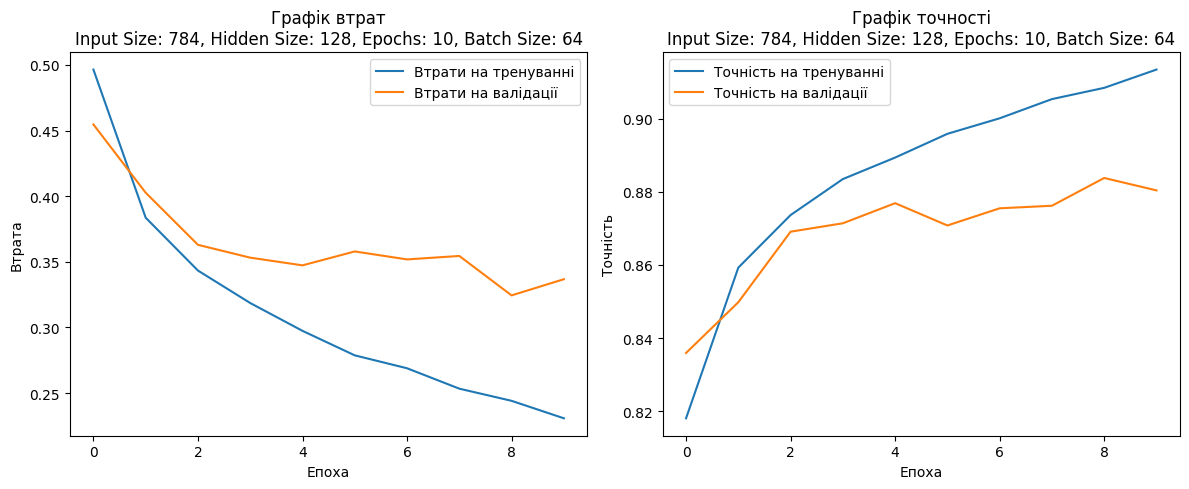

In [ ]:
# default setup
input_size = 784
hidden_size = 128
epoch_size = 10
batch_size = 64

full_setup(input_size, hidden_size, epoch_size, batch_size)

## Використаємо різну кількість нейронів у вхідному шарі

Кількість нейронів вхідного шару: 400.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7651 - loss: 0.6520 - val_accuracy: 0.8272 - val_loss: 0.4638
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8487 - loss: 0.4160 - val_accuracy: 0.8452 - val_loss: 0.4244
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8623 - loss: 0.3734 - val_accuracy: 0.8614 - val_loss: 0.3801
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8721 - loss: 0.3463 - val_accuracy: 0.8650 - val_loss: 0.3653
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8813 - loss: 0.3226 - val_accuracy: 0.8682 - val_loss: 0.3606
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8876 - loss: 0.3052 - val_accuracy: 0.8606 - val_loss: 0.3658
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8889 - loss: 0.2961 - val_accuracy: 0.8702 - val_loss: 0.3588
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accurac

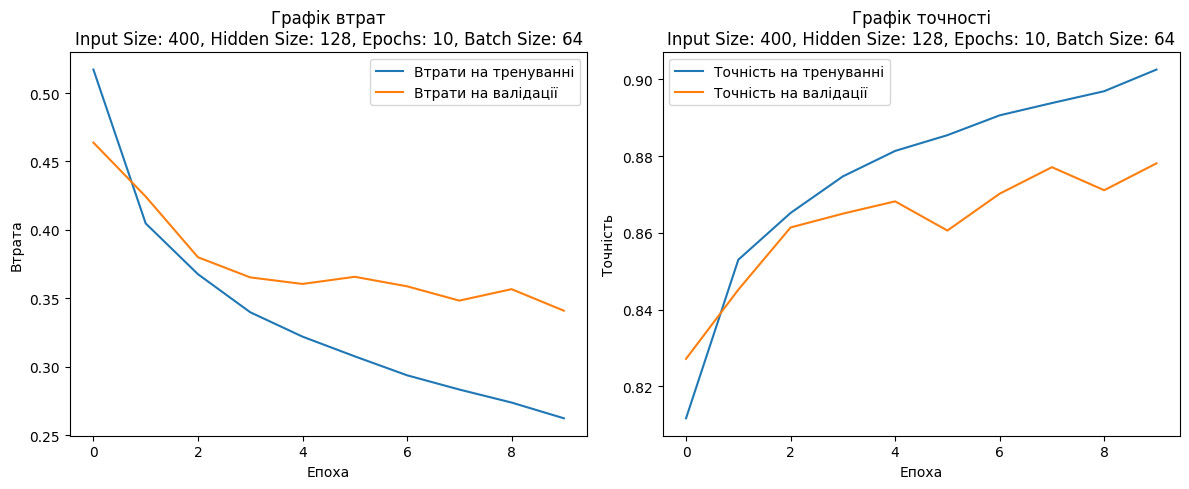

Кількість нейронів вхідного шару: 600.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7707 - loss: 0.6289 - val_accuracy: 0.8364 - val_loss: 0.4505
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8547 - loss: 0.3996 - val_accuracy: 0.8435 - val_loss: 0.4259
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8654 - loss: 0.3617 - val_accuracy: 0.8647 - val_loss: 0.3702
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8768 - loss: 0.3331 - val_accuracy: 0.8600 - val_loss: 0.3839
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8874 - loss: 0.3058 - val_accuracy: 0.8723 - val_loss: 0.3524
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8909 - loss: 0.2955 - val_accuracy: 0.8798 - val_loss: 0.3414
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8983 - loss: 0.2755 - val_accuracy: 0.8779 - val_loss: 0.3528
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accurac

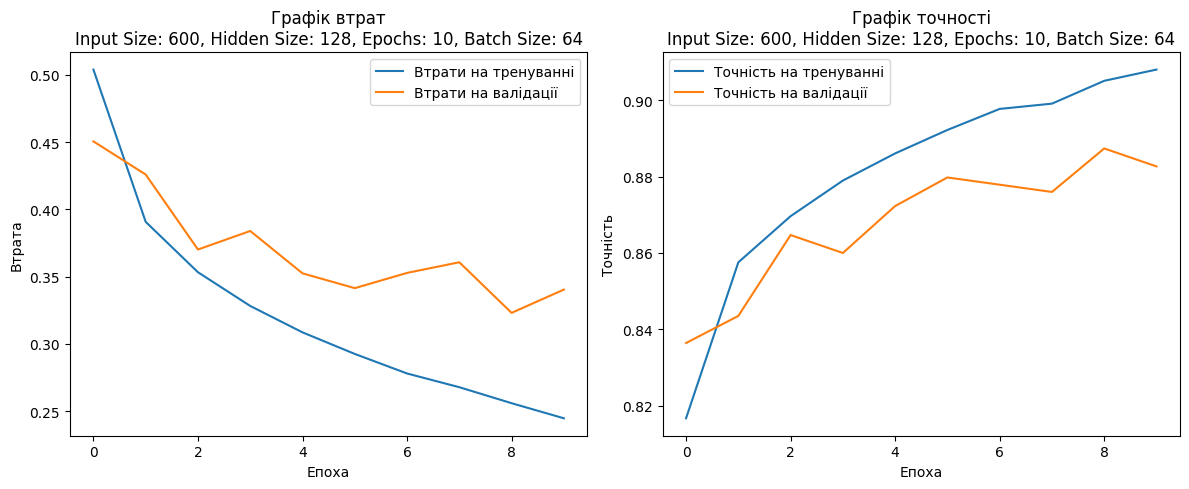

Кількість нейронів вхідного шару: 800.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7798 - loss: 0.6215 - val_accuracy: 0.8358 - val_loss: 0.4467
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8548 - loss: 0.3966 - val_accuracy: 0.8486 - val_loss: 0.4290
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8716 - loss: 0.3443 - val_accuracy: 0.8606 - val_loss: 0.3812
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8826 - loss: 0.3185 - val_accuracy: 0.8618 - val_loss: 0.3821
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8899 - loss: 0.2988 - val_accuracy: 0.8692 - val_loss: 0.3689
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8953 - loss: 0.2798 - val_accuracy: 0.8693 - val_loss: 0.3697
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8981 - loss: 0.2691 - val_accuracy: 0.8791 - val_loss: 0.3407
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accurac

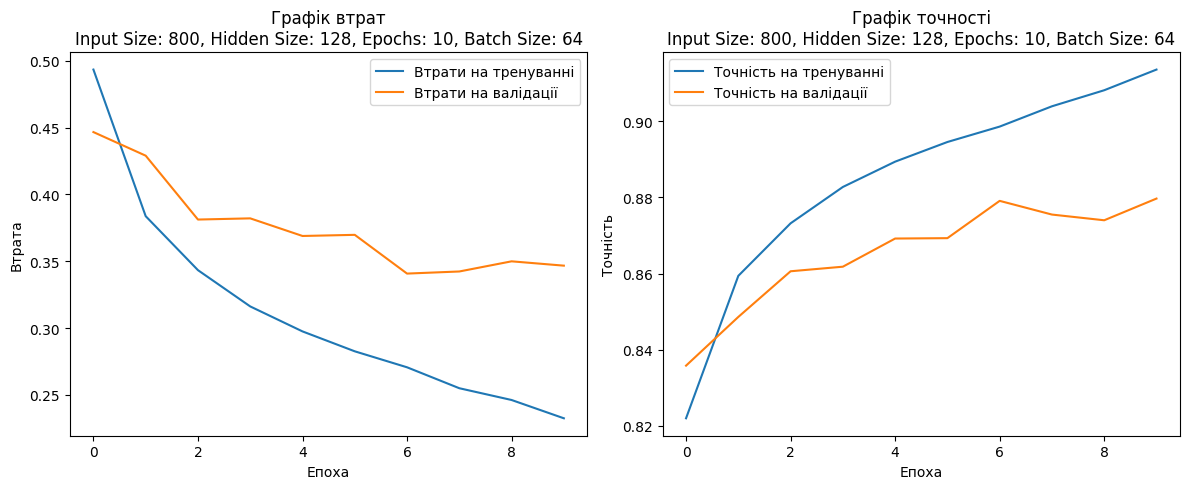

Кількість нейронів вхідного шару: 1200.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7780 - loss: 0.6077 - val_accuracy: 0.8418 - val_loss: 0.4327
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8593 - loss: 0.3816 - val_accuracy: 0.8532 - val_loss: 0.3924
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8748 - loss: 0.3390 - val_accuracy: 0.8594 - val_loss: 0.3852
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8852 - loss: 0.3102 - val_accuracy: 0.8656 - val_loss: 0.3742
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8914 - loss: 0.2922 - val_accuracy: 0.8707 - val_loss: 0.3634
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8964 - loss: 0.2768 - val_accuracy: 0.8819 - val_loss: 0.3378
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9015 - loss: 0.2636 - val_accuracy: 0.8735 - val_loss: 0.3455
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accura

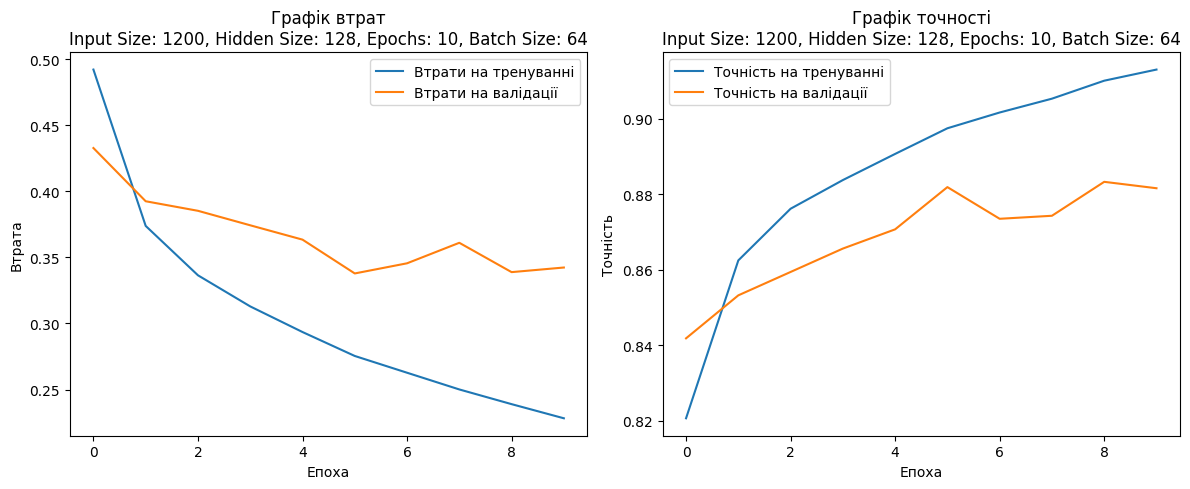

In [ ]:
# input size setup check
input_sizes = [400, 600, 800, 1200]

for curr_size in input_sizes:
  print(f"Кількість нейронів вхідного шару: {curr_size:.4f}")
  full_setup(curr_size, hidden_size, epoch_size, batch_size)

Спираючись на одержані графіки й підсумкову точність моделі, можемо зробити такі висновки:

1) Точність незначно покращується з ростом кількості нейронів у вхідному шарі, проте різниця мінімальна.

2) Оптимальними є моделі з 600 та 1200 нейронів, оскільки вони демонструють найкращі результати валідаційної точності (88.27% і 88.16% відповідно).

3) Збільшення кількості нейронів після 600 не дає суттєвого покращення, тому **600 нейронів можна вважати оптимальним варіантом** для балансу між продуктивністю та ефективністю.

## Перевіримо, як зміняться результати моделі, якщо використати різну кількість нейронів у одному з прихованих шарів

Кількість нейронів прихованого шару: 200.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7860 - loss: 0.5954 - val_accuracy: 0.8434 - val_loss: 0.4310
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8604 - loss: 0.3820 - val_accuracy: 0.8609 - val_loss: 0.3998
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8727 - loss: 0.3450 - val_accuracy: 0.8669 - val_loss: 0.3737
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8848 - loss: 0.3090 - val_accuracy: 0.8674 - val_loss: 0.3697
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8898 - loss: 0.2963 - val_accuracy: 0.8740 - val_loss: 0.3600
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8984 - loss: 0.2755 - val_accuracy: 0.8820 - val_loss: 0.3386
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9029 - loss: 0.2588 - val_accuracy: 0.8672 - val_loss: 0.3728
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - ac

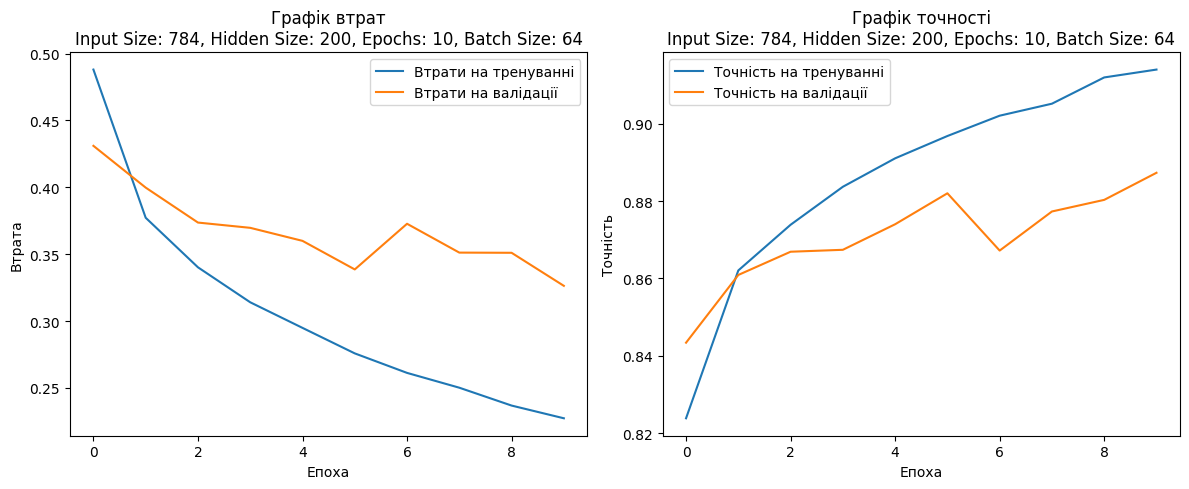

Кількість нейронів прихованого шару: 300.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7790 - loss: 0.6107 - val_accuracy: 0.8511 - val_loss: 0.4158
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8606 - loss: 0.3812 - val_accuracy: 0.8553 - val_loss: 0.3987
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8730 - loss: 0.3426 - val_accuracy: 0.8622 - val_loss: 0.3878
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8855 - loss: 0.3097 - val_accuracy: 0.8702 - val_loss: 0.3641
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8908 - loss: 0.2922 - val_accuracy: 0.8718 - val_loss: 0.3678
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8981 - loss: 0.2737 - val_accuracy: 0.8809 - val_loss: 0.3424
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9028 - loss: 0.2602 - val_accuracy: 0.8813 - val_loss: 0.3475
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - a

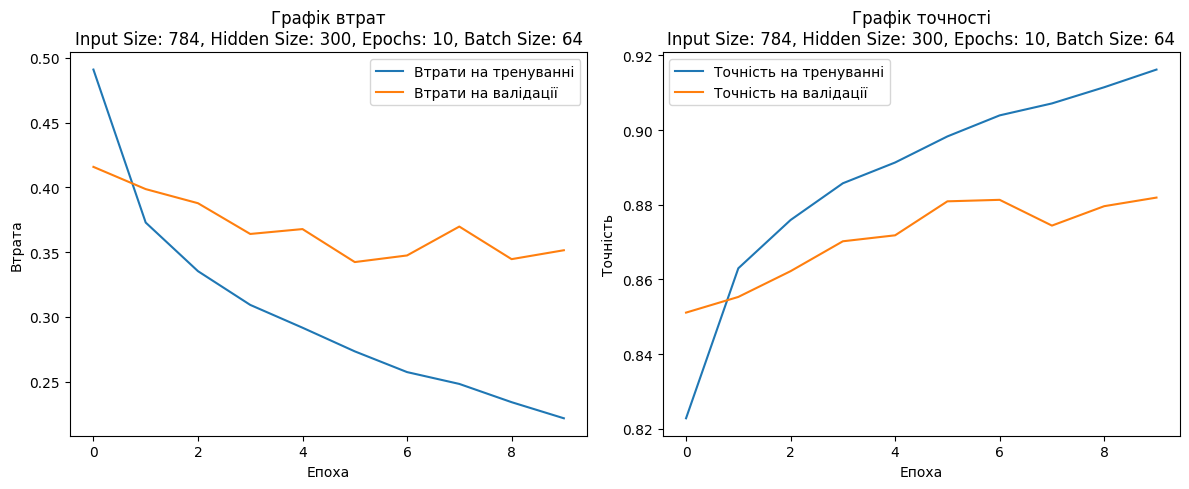

Кількість нейронів прихованого шару: 400.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.7784 - loss: 0.6087 - val_accuracy: 0.8430 - val_loss: 0.4308
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8632 - loss: 0.3747 - val_accuracy: 0.8429 - val_loss: 0.4326
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8755 - loss: 0.3384 - val_accuracy: 0.8642 - val_loss: 0.3743
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8842 - loss: 0.3122 - val_accuracy: 0.8630 - val_loss: 0.3775
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8932 - loss: 0.2920 - val_accuracy: 0.8795 - val_loss: 0.3501
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8990 - loss: 0.2689 - val_accuracy: 0.8757 - val_loss: 0.3521
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9054 - loss: 0.2522 - val_accuracy: 0.8755 - val_loss: 0.3591
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step

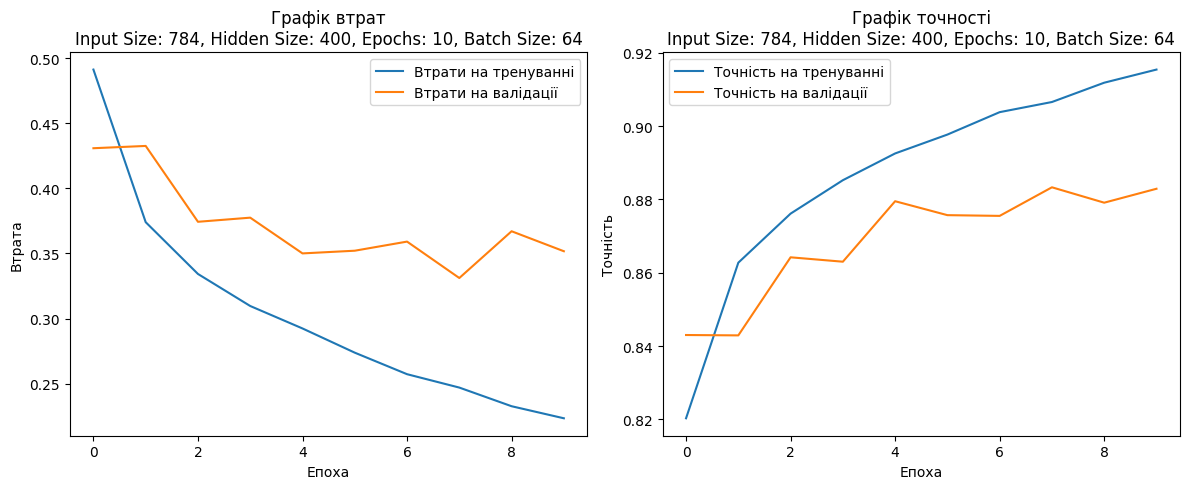

Кількість нейронів прихованого шару: 600.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7809 - loss: 0.6099 - val_accuracy: 0.8506 - val_loss: 0.4176
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8611 - loss: 0.3790 - val_accuracy: 0.8555 - val_loss: 0.3942
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8770 - loss: 0.3329 - val_accuracy: 0.8640 - val_loss: 0.3923
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8840 - loss: 0.3113 - val_accuracy: 0.8654 - val_loss: 0.3868
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8898 - loss: 0.2942 - val_accuracy: 0.8672 - val_loss: 0.3879
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8970 - loss: 0.2744 - val_accuracy: 0.8767 - val_loss: 0.3445
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9067 - loss: 0.2495 - val_accuracy: 0.8820 - val_loss: 0.3453
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 

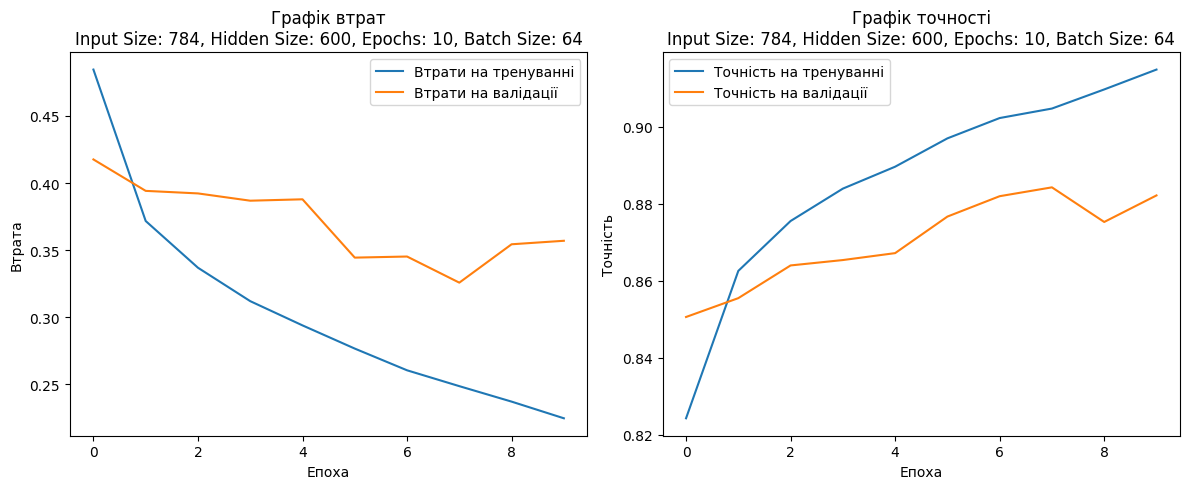

Кількість нейронів прихованого шару: 800.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.7849 - loss: 0.6108 - val_accuracy: 0.8340 - val_loss: 0.4535
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8617 - loss: 0.3762 - val_accuracy: 0.8557 - val_loss: 0.3903
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.8731 - loss: 0.3403 - val_accuracy: 0.8684 - val_loss: 0.3777
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8833 - loss: 0.3159 - val_accuracy: 0.8651 - val_loss: 0.3815
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8903 - loss: 0.2892 - val_accuracy: 0.8693 - val_loss: 0.3897
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.8951 - loss: 0.2785 - val_accuracy: 0.8709 - val_loss: 0.3862
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.8998 - loss: 0.2659 - val_accuracy: 0.8725 - val_loss: 0.3723
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 

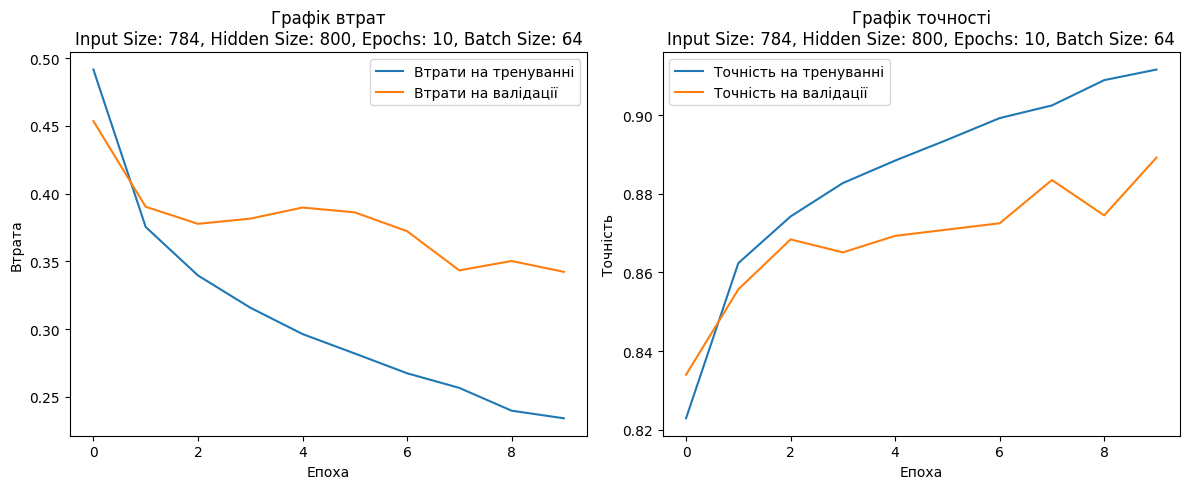

In [ ]:
# hidden size setup check
hidden_sizes = [200, 300, 400, 600, 800]

for curr_size in hidden_sizes:
  print(f"Кількість нейронів прихованого шару: {curr_size:.4f}")
  full_setup(input_size, curr_size, epoch_size, batch_size)

Збільшення кількості нейронів у прихованому шарі показує, що після певної точки валідаційна точність перестає значно покращуватись і навіть може почати коливатися, що свідчить про перенавчання.

Найкраще співвідношення точності та втрат спостерігалося при **200 нейронах у прихованому шарі**. Збільшення кількості нейронів не завжди дає кращі результати і може призвести до перенавчання, що спостерігається зокрема при 400 та більше нейронах.

## Проаналізуємо поведінку моделі у випадку зміни кількості епох навчання

Кількість епох: 10.0000
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7780 - loss: 0.6124 - val_accuracy: 0.8390 - val_loss: 0.4399
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8604 - loss: 0.3846 - val_accuracy: 0.8527 - val_loss: 0.4078
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8702 - loss: 0.3513 - val_accuracy: 0.8589 - val_loss: 0.3818
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8832 - loss: 0.3135 - val_accuracy: 0.8724 - val_loss: 0.3596
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8914 - loss: 0.2906 - val_accuracy: 0.8693 - val_loss: 0.3653
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8954 - loss: 0.2773 - val_accuracy: 0.8772 - val_loss: 0.3518
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9036 - loss: 0.2596 - val_accuracy: 0.8741 - val_loss: 0.3538
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9067 - loss:

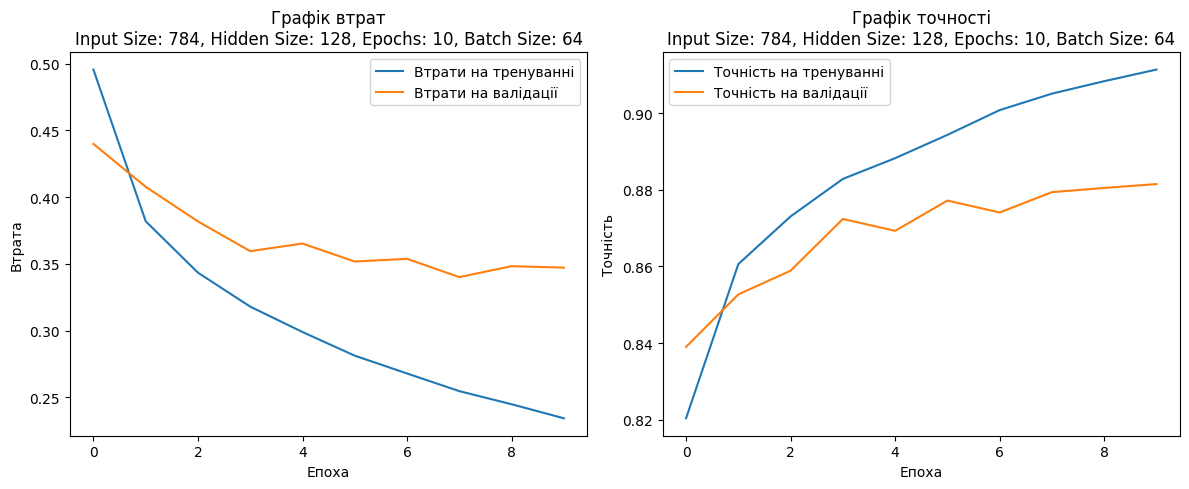

Кількість епох: 15.0000
Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7806 - loss: 0.6162 - val_accuracy: 0.8239 - val_loss: 0.4840
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8561 - loss: 0.3969 - val_accuracy: 0.8561 - val_loss: 0.3923
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8717 - loss: 0.3518 - val_accuracy: 0.8578 - val_loss: 0.3953
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8815 - loss: 0.3208 - val_accuracy: 0.8664 - val_loss: 0.3601
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8875 - loss: 0.3058 - val_accuracy: 0.8740 - val_loss: 0.3493
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8969 - loss: 0.2824 - val_accuracy: 0.8730 - val_loss: 0.3507
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8980 - loss: 0.2683 - val_accuracy: 0.8804 - val_loss: 0.3336
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9065 - loss: 0

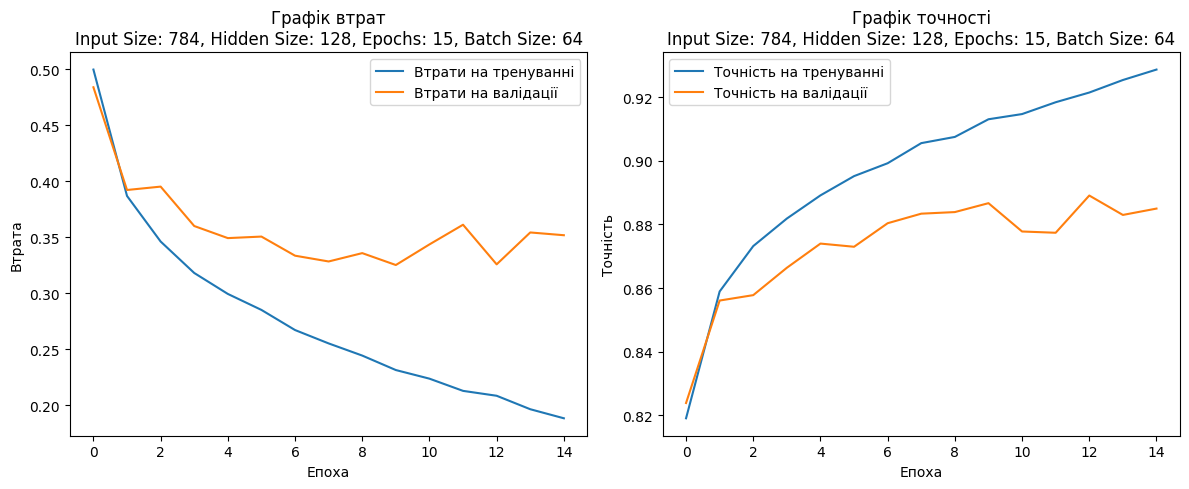

Кількість епох: 20.0000
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7778 - loss: 0.6213 - val_accuracy: 0.8451 - val_loss: 0.4301
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8583 - loss: 0.3872 - val_accuracy: 0.8523 - val_loss: 0.4090
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8714 - loss: 0.3490 - val_accuracy: 0.8686 - val_loss: 0.3679
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8834 - loss: 0.3106 - val_accuracy: 0.8674 - val_loss: 0.3766
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8894 - loss: 0.2982 - val_accuracy: 0.8742 - val_loss: 0.3546
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8950 - loss: 0.2789 - val_accuracy: 0.8809 - val_loss: 0.3361
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9014 - loss: 0.2663 - val_accuracy: 0.8757 - val_loss: 0.3493
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9044 - loss: 0

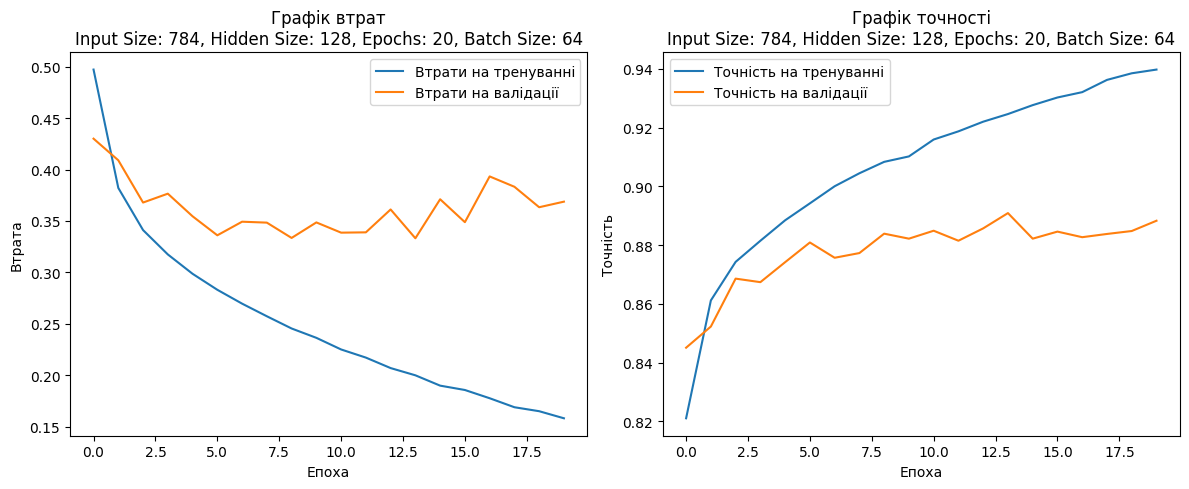

Кількість епох: 25.0000
Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7791 - loss: 0.6272 - val_accuracy: 0.8417 - val_loss: 0.4352
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8559 - loss: 0.3939 - val_accuracy: 0.8527 - val_loss: 0.4046
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8724 - loss: 0.3492 - val_accuracy: 0.8605 - val_loss: 0.3889
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8813 - loss: 0.3208 - val_accuracy: 0.8620 - val_loss: 0.3793
Epoch 5/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8893 - loss: 0.2989 - val_accuracy: 0.8744 - val_loss: 0.3491
Epoch 6/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8953 - loss: 0.2840 - val_accuracy: 0.8748 - val_loss: 0.3529
Epoch 7/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8996 - loss: 0.2677 - val_accuracy: 0.8785 - val_loss: 0.3452
Epoch 8/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9042 - loss: 

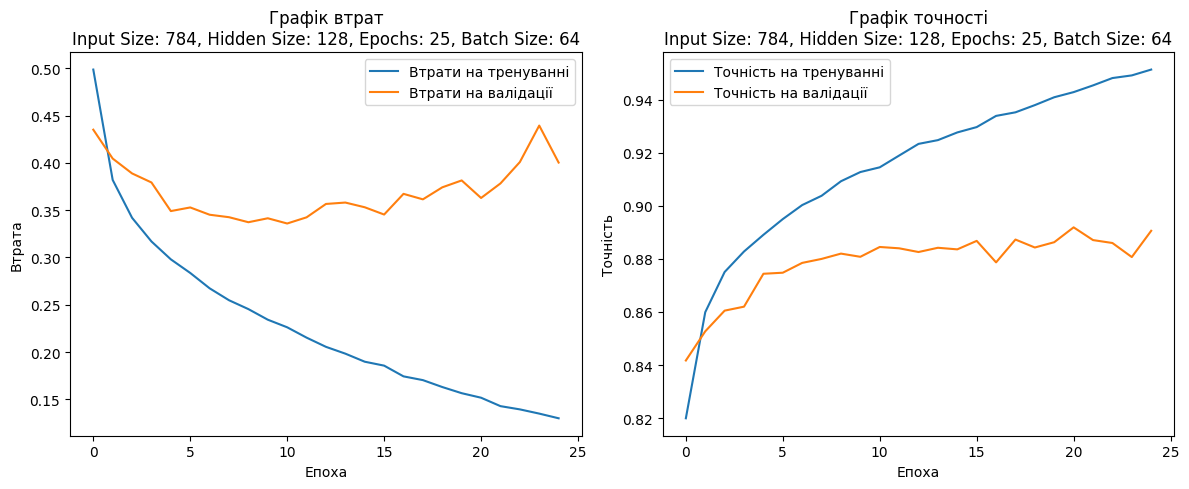

Кількість епох: 30.0000
Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7770 - loss: 0.6168 - val_accuracy: 0.8328 - val_loss: 0.4676
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8577 - loss: 0.3875 - val_accuracy: 0.8478 - val_loss: 0.4063
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8749 - loss: 0.3402 - val_accuracy: 0.8566 - val_loss: 0.3909
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8834 - loss: 0.3134 - val_accuracy: 0.8738 - val_loss: 0.3584
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8909 - loss: 0.2952 - val_accuracy: 0.8698 - val_loss: 0.3654
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8957 - loss: 0.2799 - val_accuracy: 0.8780 - val_loss: 0.3394
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9017 - loss: 0.2615 - val_accuracy: 0.8768 - val_loss: 0.3470
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9053 - loss: 

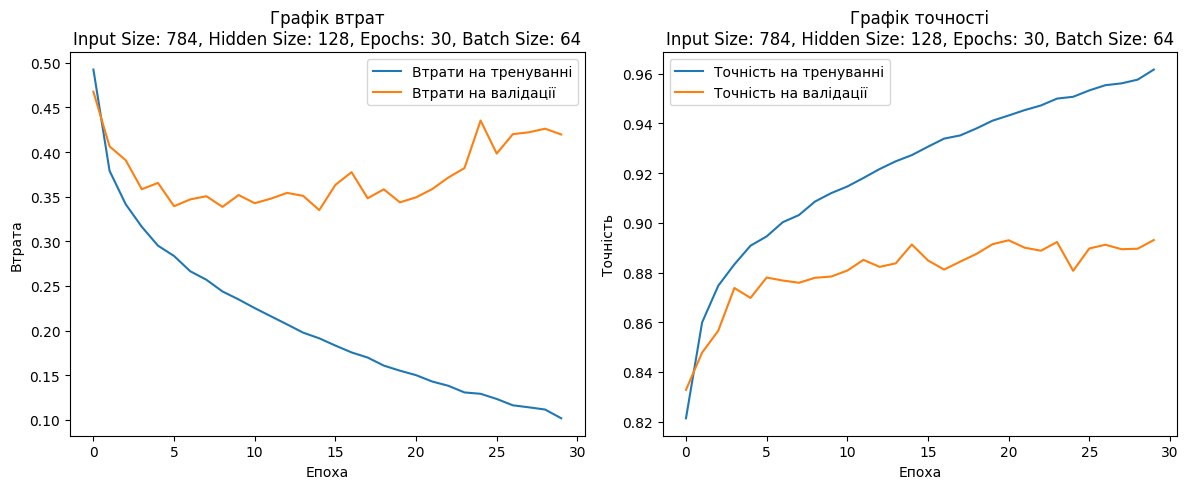

In [ ]:
# epoch size setup check
epoch_sizes = [10, 15, 20, 25, 30]

for curr_size in epoch_sizes:
  print(f"Кількість епох: {curr_size:.4f}")
  full_setup(input_size, hidden_size, curr_size, batch_size)

Спираючись на отримані дані, можемо зробити такі проміжні висновки

1) Збільшення кількості епох дає покращення валідаційної точності, хоча різниця між 15 і 20 епохами вже незначна.

2) Втрата на валідаційному наборі трохи зросла після 20 епох, що може вказувати на початок перенавчання (overfitting).

3) Найкраща точність на валідації була досягнута у разі 20 епох (0.8883), але варто звернути увагу на втрату — її збільшення може сигналізувати про те, що кількість епох варто обмежити, щоб уникнути перенавчання.

Таким чином, для даної моделі можуть бути найбільш оптимальними **15-20 епох**.

## Виконаємо аналіз побудованої моделі для різних розмірів міні-вибірки

Розмір міні-вибірки: 10.0000
Epoch 1/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7884 - loss: 0.5915 - val_accuracy: 0.8422 - val_loss: 0.4400
Epoch 2/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.8560 - loss: 0.3868 - val_accuracy: 0.8568 - val_loss: 0.3900
Epoch 3/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.8715 - loss: 0.3465 - val_accuracy: 0.8598 - val_loss: 0.3846
Epoch 4/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8851 - loss: 0.3102 - val_accuracy: 0.8648 - val_loss: 0.3715
Epoch 5/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8888 - loss: 0.2952 - val_accuracy: 0.8675 - val_loss: 0.3568
Epoch 6/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.8945 - loss: 0.2810 - val_accuracy: 0.8780 - val_loss: 0.3459
Epoch 7/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9019 - loss: 0.2609 - val_accuracy: 0.8724 - val_loss: 0.3794
Epoch 8/10
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step

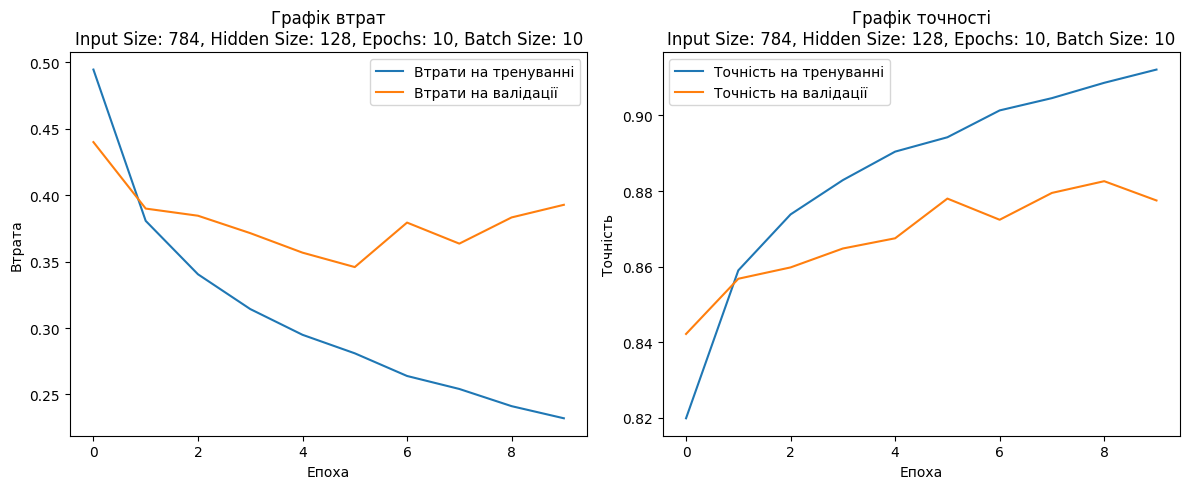

Розмір міні-вибірки: 50.0000
Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7770 - loss: 0.6147 - val_accuracy: 0.8310 - val_loss: 0.4584
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8571 - loss: 0.3873 - val_accuracy: 0.8518 - val_loss: 0.3958
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8740 - loss: 0.3429 - val_accuracy: 0.8552 - val_loss: 0.3904
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8794 - loss: 0.3238 - val_accuracy: 0.8714 - val_loss: 0.3526
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8912 - loss: 0.2906 - val_accuracy: 0.8742 - val_loss: 0.3518
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8972 - loss: 0.2772 - val_accuracy: 0.8726 - val_loss: 0.3533
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9018 - loss: 0.2596 - val_accuracy: 0.8723 - val_loss: 0.3640
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - a

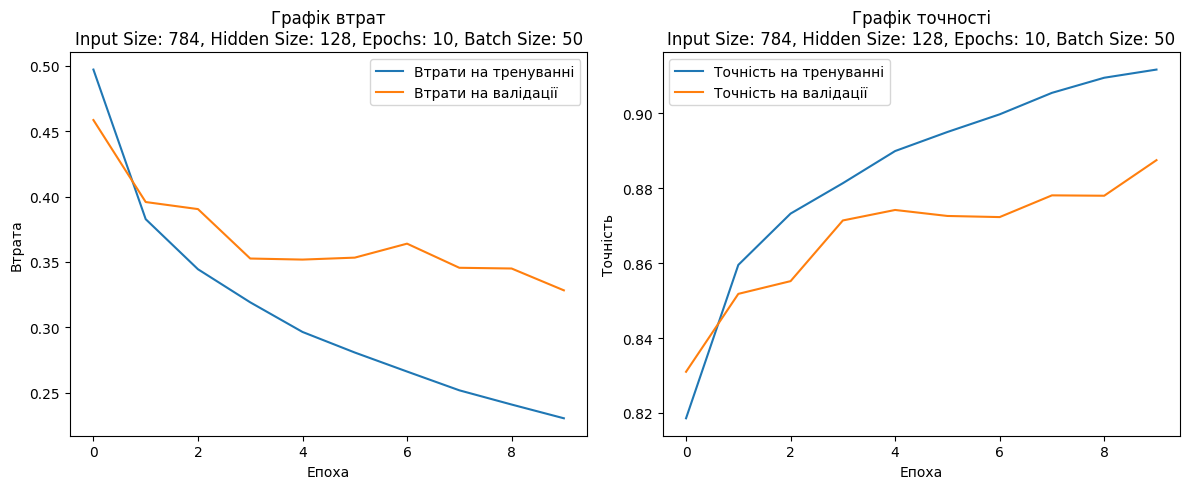

Розмір міні-вибірки: 100.0000
Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7717 - loss: 0.6403 - val_accuracy: 0.8402 - val_loss: 0.4368
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8575 - loss: 0.3929 - val_accuracy: 0.8449 - val_loss: 0.4070
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8679 - loss: 0.3562 - val_accuracy: 0.8612 - val_loss: 0.3966
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8823 - loss: 0.3197 - val_accuracy: 0.8630 - val_loss: 0.3798
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8876 - loss: 0.3093 - val_accuracy: 0.8667 - val_loss: 0.3663
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8936 - loss: 0.2836 - val_accuracy: 0.8739 - val_loss: 0.3530
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8964 - loss: 0.2757 - val_accuracy: 0.8768 - val_loss: 0.3397
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9011 - l

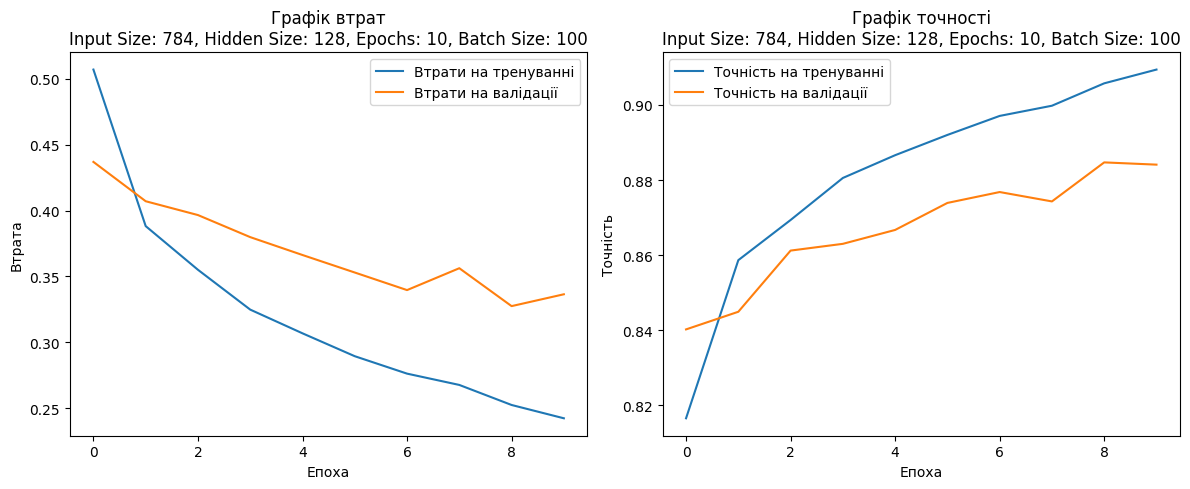

Розмір міні-вибірки: 200.0000
Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7449 - loss: 0.7339 - val_accuracy: 0.8361 - val_loss: 0.4610
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8496 - loss: 0.4186 - val_accuracy: 0.8507 - val_loss: 0.4108
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8678 - loss: 0.3633 - val_accuracy: 0.8533 - val_loss: 0.3953
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8741 - loss: 0.3446 - val_accuracy: 0.8586 - val_loss: 0.3893
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8816 - loss: 0.3215 - val_accuracy: 0.8662 - val_loss: 0.3677
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8867 - loss: 0.3062 - val_accuracy: 0.8732 - val_loss: 0.3526
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8926 - loss: 0.2906 - val_accuracy: 0.8761 - val_loss: 0.3470
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8997 - 

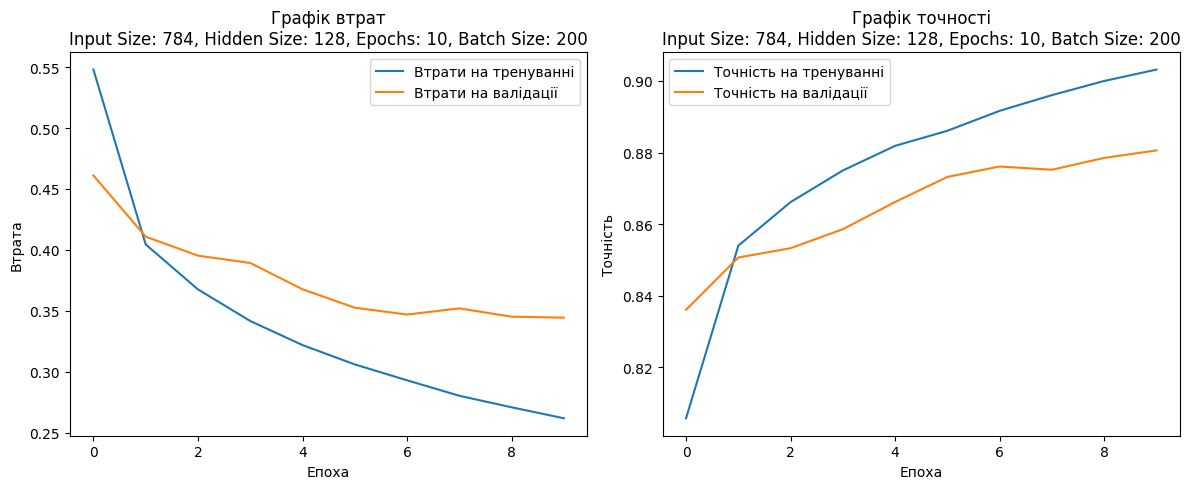

Розмір міні-вибірки: 500.0000
Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6830 - loss: 0.9074 - val_accuracy: 0.8272 - val_loss: 0.4886
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8376 - loss: 0.4517 - val_accuracy: 0.8363 - val_loss: 0.4504
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8539 - loss: 0.4059 - val_accuracy: 0.8504 - val_loss: 0.4231
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8646 - loss: 0.3788 - val_accuracy: 0.8567 - val_loss: 0.4071
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8701 - loss: 0.3591 - val_accuracy: 0.8614 - val_loss: 0.3913
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8759 - loss: 0.3380 - val_accuracy: 0.8578 - val_loss: 0.3877
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8824 - loss: 0.3255 - val_accuracy: 0.8669 - val_loss: 0.3721
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.

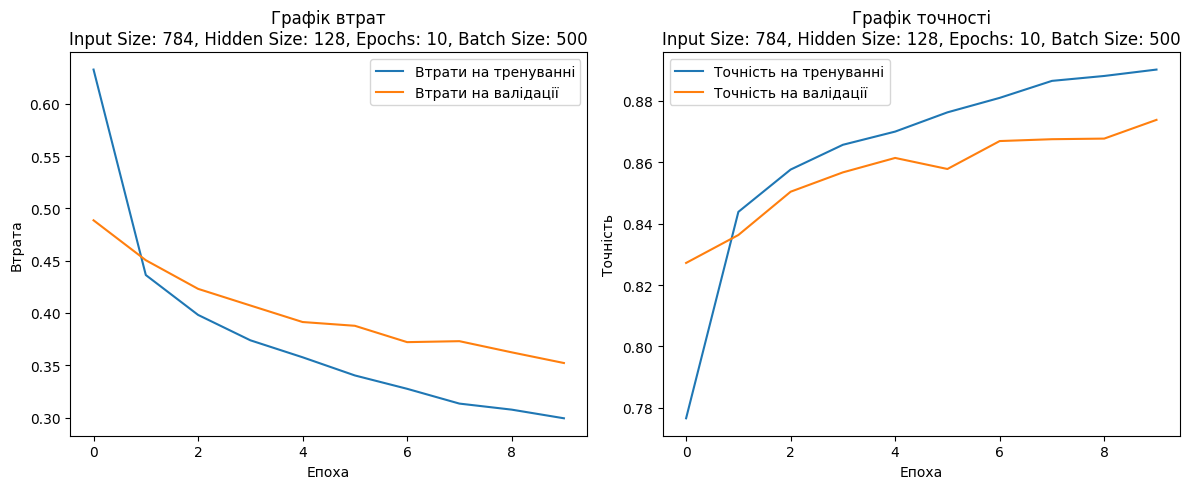

In [ ]:
# batch size setup check
batch_sizes = [10, 50, 100, 200, 500]

for curr_size in batch_sizes:
  print(f"Розмір міні-вибірки: {curr_size:.4f}")
  full_setup(input_size, hidden_size, epoch_size, curr_size)

Можна помітити тенденцію щодо ефекту розміру міні-вибірки на навчання моделі. Збільшення розміру міні-вибірки може зменшувати час на одну ітерацію навчання, оскільки більше прикладів обробляється за один крок, проте це може погіршувати швидкість адаптації моделі до даних:

* Малий розмір міні-вибірки (Batch Size: 10):

> Тривалість кожної ітерації більша, однак модель показує кращу точність на валідаційній вибірці. Загалом точність на валідації близько 87.75%, але з більшою втратою (валід. втрата = 0.3928).


* Середній розмір міні-вибірки (Batch Size: 50-100):

> Оптимальний компроміс між швидкістю навчання і точністю. Валідаційна точність стабільно тримається на рівні 88% (при розмірі 50 – 0.8875%, при 100 – 0.8841%).

* Великий розмір міні-вибірки (Batch Size: 200-500):

> Кожен крок тренування виконується швидше, однак точність може не значно покращуватись (валід. точність 87.91-88.06%). Тренування стає менш чутливим до змін на кожному кроці через більший обсяг даних.


Отже, розмір міні-вибірки **50** є найоптимальнішим.

## Змінимо кількість прихованих шарів, додавши три нових

In [ ]:
# додамо кілька прихованих шарів у модель
def model_setup_with_extra_hidden_layers(input_size=784, hidden_size=128, epoch_size=10, _batch_size=64):
  # Створюємо модель багатошарового персептрона (MLP)
  model = models.Sequential()
  model.add(layers.Dense(hidden_size, input_shape=(input_size,), activation='elu'))  # перший прихований шар
  model.add(layers.Dense(128, activation='elu'))  # другий прихований шар

  model.add(layers.Dense(100, activation='elu'))  # третій прихований шар
  model.add(layers.Dense(280, activation='elu'))  # четвертий прихований шар
  model.add(layers.Dense(190, activation='elu'))  # п'ятий прихований шар

  model.add(layers.Dense(10, activation='softmax'))  # вихідний шар

  # Компілюємо модель
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  # Змінимо розмір зображень до необхідного для моделі розміру
  x_train_resized = process_images_in_batches(x_train_float, input_size)
  x_val_resized = process_images_in_batches(x_val_float, input_size)


  # Навчаємо модель
  # Потрібно перетворити зображення до очікуваного розміру, який визначається кількістю нейронів вхідного шару нейромережі
  history = model.fit(
      x_train_resized,
      y_train_oh,
      batch_size=_batch_size,
      epochs=epoch_size,
      validation_data=(x_val_resized, y_val_oh)
  )

  return model, history


In [ ]:
def full_setup(input_size=784, hidden_size=128, epoch_size=10, batch_size=64):
  model, history = model_setup_with_extra_hidden_layers(input_size, hidden_size, epoch_size, batch_size);

  # Оцінюємо модель на валідаційному наборі
  x_val_resized = process_images_in_batches(x_val_float, input_size)

  val_loss, val_accuracy = model.evaluate(x_val_resized, y_val_oh)
  print(f"Валідаційна точність: {val_accuracy:.4f}\nInput Size: {input_size}, Hidden Size: {hidden_size}, Epochs: {epoch_size}, Batch Size: {batch_size}")

  # Побудуємо графік втрат під час навчання й точності моделі
  plot_metrics(history, input_size, hidden_size, epoch_size, batch_size)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7730 - loss: 0.6252 - val_accuracy: 0.8289 - val_loss: 0.4789
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8499 - loss: 0.4071 - val_accuracy: 0.8456 - val_loss: 0.4258
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8664 - loss: 0.3596 - val_accuracy: 0.8628 - val_loss: 0.3783
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8722 - loss: 0.3435 - val_accuracy: 0.8698 - val_loss: 0.3650
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8818 - loss: 0.3141 - val_accuracy: 0.8746 - val_loss: 0.3521
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8879 - loss: 0.3022 - val_accuracy: 0.8796 - val_loss: 0.3378
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8953 - loss: 0.2805 - val_accuracy: 0.8633 - val_loss: 0.3784
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9003 - loss: 0.2677 - val_accuracy:

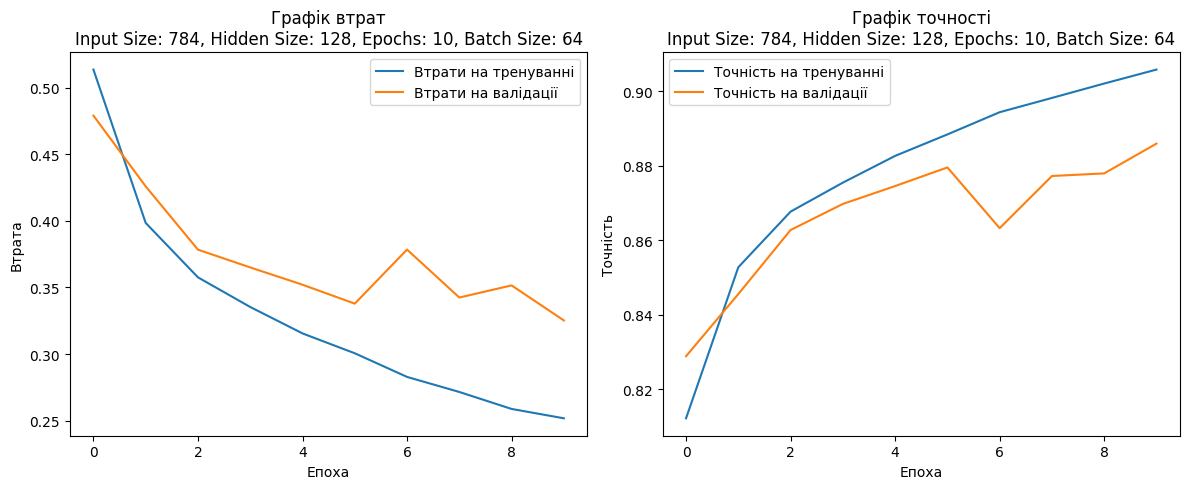

In [ ]:
full_setup()

Збільшення кількості прихованих шарів покращило точність моделі, але також призвело до більш тривалої обробки кожної епохи.

* Початкова модель (з меншою кількістю шарів) мала точність на валідації 0.8804.
* Після збільшення кількості шарів точність покращилась до 0.8860.
При цьому, час обробки кожної епохи також зріс.

Така поведінка свідчить про те, що додавання прихованих шарів допомагає краще виявляти складні патерни, проте це також збільшує витрати на обчислення.

## Отож, на основі отриманих результатів, побудуємо неромережу, яка матиме найбільш оптимальні гіперпараметри

* Кількість нейронів вхідного шару: 600
* Кількість нейронів прихованого шару: 200
* Кількість епох: 15
* Розмір міні-вибірки: 50
* Додаткові приховані шари з різною кількістю нейронів: 3

In [ ]:
def best_full_setup(input_size=784, hidden_size=128, epoch_size=10, batch_size=64):
  model, history = model_setup_with_extra_hidden_layers(input_size, hidden_size, epoch_size, batch_size);

  # Оцінюємо модель на валідаційному наборі
  x_val_resized = process_images_in_batches(x_val_float, input_size)

  val_loss, val_accuracy = model.evaluate(x_val_resized, y_val_oh)
  print(f"Валідаційна точність: {val_accuracy:.4f}\nInput Size: {input_size}, Hidden Size: {hidden_size}, Epochs: {epoch_size}, Batch Size: {batch_size}")

  # Побудуємо графік втрат під час навчання й точності моделі
  plot_metrics(history, input_size, hidden_size, epoch_size, batch_size)

  return model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.7729 - loss: 0.6162 - val_accuracy: 0.8342 - val_loss: 0.4466
Epoch 2/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8512 - loss: 0.4037 - val_accuracy: 0.8497 - val_loss: 0.4096
Epoch 3/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8658 - loss: 0.3622 - val_accuracy: 0.8529 - val_loss: 0.4066
Epoch 4/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8761 - loss: 0.3364 - val_accuracy: 0.8658 - val_loss: 0.3647
Epoch 5/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8832 - loss: 0.3182 - val_accuracy: 0.8519 - val_loss: 0.3904
Epoch 6/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8882 - loss: 0.3032 - val_accuracy: 0.8760 - val_loss: 0.3452
Epoch 7/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8968 - loss: 0.2829 - val_accuracy: 0.8673 - val_loss: 0.3758
Epoch 8/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.8988 - loss

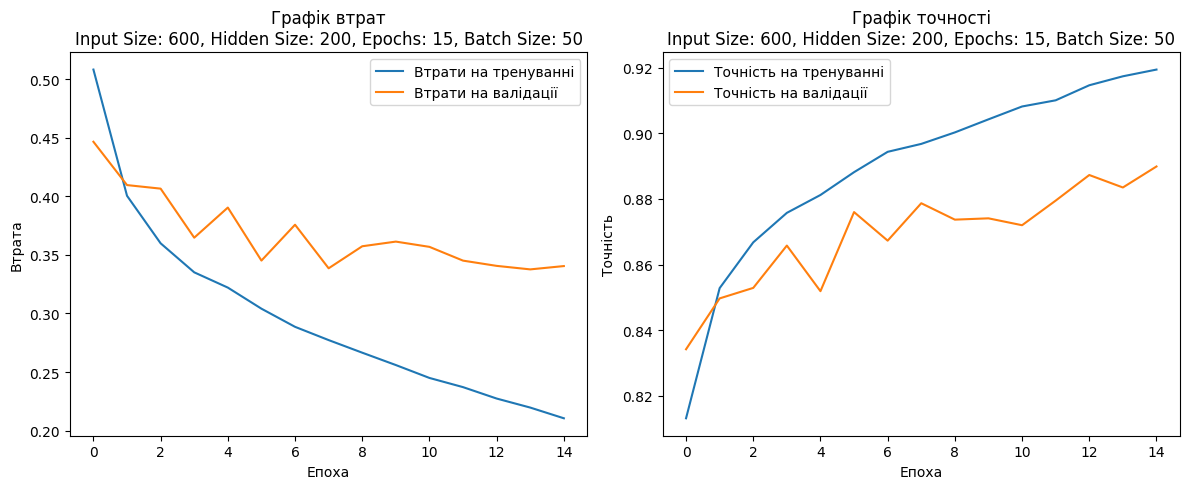

In [ ]:
input = 600
hidden = 200
epochs = 15
batches=50

best_model = best_full_setup(input, hidden, epochs, batches)

## Здійснимо крос-валідацію для того, щоб оцінити здатність моделі до генералізації даних й уникнути перенавчання

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

def cross_validate_model(input_size=784, hidden_size=128, epoch_size=10, batch_size=64, n_splits=5):
    # Підготовка даних
    x_val_resized = process_images_in_batches(x_val_float, input_size)

    # Ініціалізація KFold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []

    # Перехресна перевірка
    for train_index, val_index in kf.split(x_val_resized):
        x_train_fold, x_val_fold = x_val_resized[train_index], x_val_resized[val_index]
        y_train_fold, y_val_fold = y_val_oh[train_index], y_val_oh[val_index]

        # Налаштування моделі для поточної частини
        model, history = model_setup_with_extra_hidden_layers(input_size, hidden_size, epoch_size, batch_size)

        # Оцінка моделі на валідаційній частині
        val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold)
        fold_accuracies.append(val_accuracy)  # Збереження валідаційної точності для поточної частини

        print(f"Валідаційна точність на частині: {val_accuracy:.4f}")

    # Середня точність по всіх частинах
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Середня валідаційна точність по всіх частинах: {mean_accuracy:.4f}')

    return mean_accuracy

In [ ]:
# Виклик функції для перехресної перевірки
cross_validate_model(input, hidden, epochs, batches, n_splits=5)

Epoch 1/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7816 - loss: 0.5974 - val_accuracy: 0.8250 - val_loss: 0.4774
Epoch 2/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8497 - loss: 0.4099 - val_accuracy: 0.8548 - val_loss: 0.4070
Epoch 3/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8662 - loss: 0.3635 - val_accuracy: 0.8455 - val_loss: 0.4267
Epoch 4/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8744 - loss: 0.3409 - val_accuracy: 0.8667 - val_loss: 0.3712
Epoch 5/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - accuracy: 0.8817 - loss: 0.3145 - val_accuracy: 0.8657 - val_loss: 0.3888
Epoch 6/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.8878 - loss: 0.2992 - val_accuracy: 0.8768 - val_loss: 0.3539
Epoch 7/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8928 - loss: 0.2821 - val_accuracy: 0.8686 - val_loss: 0.3713
Epoch 8/15
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8979 - loss: 

0.884499990940094

# Висновок
На основі проведеного аналізу навчання моделі для класифікації одягу з датасета Fashion MNIST, можна зробити наступний загальний висновок.

Модель демонструє позитивні результати, оскільки точність на тренувальному наборі даних зросла з 77.29% до 91.97% за 15 епох навчання. Втрата також зменшилася, що свідчить про покращення в навчанні. Що важливо, валідаційна точність зросла з 83.42% до **88.99% (середня точність 88.45%)**, і втрати на валідаційних даних зменшилися з 0.4466 до 0.3405. Ці показники свідчать про те, що модель не лише успішно навчається на тренувальних даних, а й добре узагальнює валідаційні дані.

На основі аналізу результатів, **не виявлено ознак перенавчання**. Валідаційна точність не лише підвищується, а й залишається близькою до тренувальної точності. Втрата на валідаційних даних не демонструє зростання, що є позитивним знаком.

Отже, модель успішно балансує між навчанням і узагальненням, що свідчить про те, що гіперпараметри було підібрано оптимальним чином.